## Goes from the input of synthesizer_working (C) to a pickle file 
## with the template of the model streams

In [1]:
# simmulate songs from three parameter series (arranges the series too)
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
import h5py
import copy
import glob
import shutil

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
from swissknife.h5tools import h5tools
from swissknife.h5tools import tables
from swissknife.dynamo import finch as zf
from swissknife.dynamo import takens as tk
from swissknife.bci.core import expstruct as es
from swissknife.bci import synthetic as syn
from swissknife.streamtools import streams as st

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

2017-10-24 11:49:58,035 root         INFO     Computer: passaro


In [2]:
sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 23500.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6,
            'Rh': 6E5,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': 0.1,
            'noise_fraction_env': 0.1,
            's_f': 44100.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2,
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1,
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

#lines, ab_g= tk.cusp_grid()
#lines, ab_g = tk.cusp_grid(b_max=0.075, b_min=-1 / 3, a_step=1.5E-3, b_steps=1000, b_log_step_exp=6, f_max=None)
# plt.plot(lines[:,1], lines[:,0])
# plt.plot(lines[:,2], lines[:,0])
# plt.plot(ab_g[:,0], ab_g[:,1], '.')

In [57]:
#load values of alpha, beta
bird = 'z028'
sess = 'day-2017-10-21'
syn_sess = 1

fn = es.file_names(bird, '{:03d}'.format(syn_sess))

alpha, beta, env = syn.load_alpha_beta(bird, syn_sess=syn_sess, s_f=44100, new_s_f=30000)

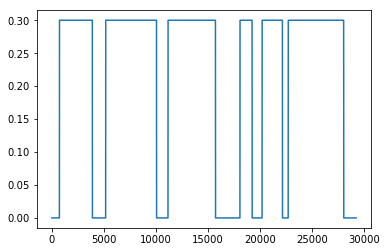

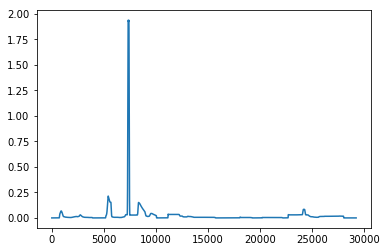

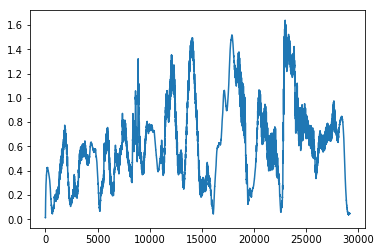

In [58]:
plt.plot(alpha)
plt.figure()
plt.plot(beta)
plt.figure()
plt.plot(env)

In [59]:
def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    return np.vstack([0.15 - onof, -beta, alpha]).T



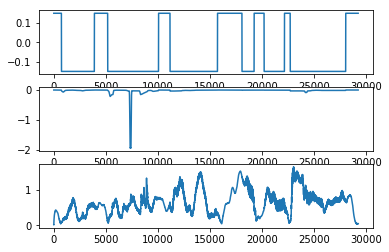

In [60]:
streams = latent_to_stream(alpha, beta, env)
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(streams[:, i]);

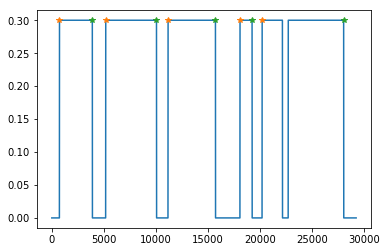

In [105]:
from swissknife.streamtools import streams as st

def get_on_clusters(intensity):
    # get the below/above threshold
    min_sil_duration = 600 #samples
    silences = np.where(intensity==0)[0]
    no_silences = np.where(intensity>0)[0]
    onoff = np.ones_like(intensity, dtype=np.short)
    onoff[silences]=0
    
    # get segments of song/silence
    onsets = np.where(np.diff(onoff)==1)[0]
    offsets = np.where(np.diff(onoff)==-1)[0] 
    if onsets[0] > offsets[0]:
        onsets = np.concatenate([np.array([0]), onsets])
    if onsets[-1] > offsets[-1]:
        offsets = np.concatenate([offsets, np.array([intensity.size])])
    on_segments = np.vstack([onsets, offsets]).T
    
    # filter 'silence' shorter that what a syllable should last
    short_offs = (np.where(np.diff(on_segments.flatten()) < min_sil_duration)[0])
    remove_elem = np.vstack([short_offs, short_offs + 1]).T.flatten()
    on_segments = np.delete(on_segments, remove_elem).reshape([-1, 2])
    
    return on_segments

on_segs = get_on_clusters(alpha)
plt.plot(alpha)
plt.plot(on_segs, np.ones_like(on_segs)*0.3, '*')

In [106]:
on_segs

array([[  729,  3888],
       [ 5166, 10045],
       [11147, 15701],
       [18050, 19215],
       [20173, 28002]])

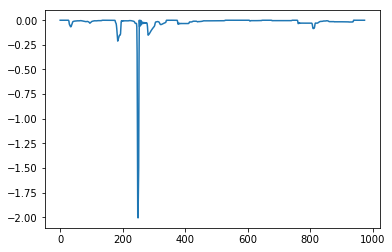

In [107]:
step_samples = 30

msec_alpha = st.decimate(alpha, step_samples)
msec_beta = - st.decimate(beta, step_samples)
msec_env = st.decimate(env, step_samples)
msec_beta[msec_beta>0] = 0
msec_env[msec_env<0] = 0
plt.plot(msec_beta)

# make the ms-sampled templates per syllable
# get the syllable starts
#mot_templates = pd.DataFrame

out_a = []
out_b = []
out_e = []
start = []
end = []
duration = []
for i, seg in enumerate(on_segs):
    start.append(seg[0]//step_samples)
    end.append(seg[1]//step_samples)
    duration.append(end[i] - start[i])
    out_a.append(msec_alpha[start[i]:end[i]])
    out_b.append(msec_beta[start[i]:end[i]])
    out_e.append(msec_env[start[i]:end[i]])
    
mot_templates = {
    field: var for field, var in zip(['alpha', 'beta', 'env', 'start', 'duration', 'end', 'syl_type'],
                                    [out_a, out_b, out_e, start, duration, end, range(i)])
}

import pickle
out_fn = os.path.join(fn['folders']['stim'], 'syl_templates_ms.p')
pickle.dump(mot_templates, open(out_fn, 'wb'), protocol=2)


In [108]:
mot_templates

{'alpha': [array([  0.00000000e+00,   2.26702925e-07,   2.74469865e-04,
           1.17631186e-02,   1.05490377e-01,   3.04279847e-01,
           3.42689062e-01,   2.59230510e-01,   3.11072846e-01,
           2.97160495e-01,   2.84333322e-01,   3.08161589e-01,
           2.83514259e-01,   3.01525906e-01,   2.93152314e-01,
           2.92772814e-01,   2.99121170e-01,   2.90031516e-01,
           2.98972893e-01,   2.92310149e-01,   2.95581891e-01,
           2.95746474e-01,   2.92969269e-01,   2.97048223e-01,
           2.93025725e-01,   2.95953055e-01,   2.94635318e-01,
           2.94371770e-01,   2.95777845e-01,   2.93866460e-01,
           2.95662672e-01,   2.94425650e-01,   2.94911008e-01,
           2.95127266e-01,   2.94431432e-01,   2.95311638e-01,
           2.94520887e-01,   2.95036322e-01,   2.94866231e-01,
           2.94727801e-01,   2.95065878e-01,   2.94663631e-01,
           2.95009674e-01,   2.94797162e-01,   2.94851964e-01,
           2.94932086e-01,   2.94769775e-01,  

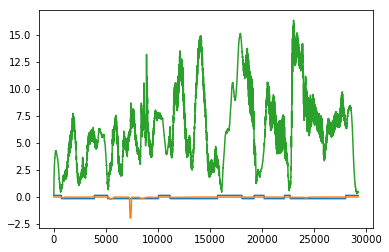

In [64]:
plt.plot(latent_to_stream(alpha, beta, env*10))

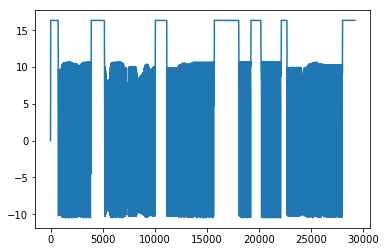

In [65]:
#reload(zf)
song_synth = zf.finch(vocal_pars, latent_to_stream(alpha, beta*2, env*10))
plt.plot(song_synth[:, 0])

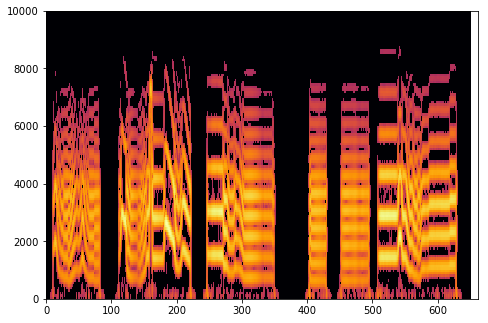

In [68]:
spectr_bos, ax = plot_spectrogram(song_synth[:, 0]*1000, 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1)

In [65]:
fig_path = es.file_names(bird, '{:03d}'.format(syn_sess))
fig_fname = os.path.join(fig_path['folders']['stim'], 'synthesis_smooth_a.eps')
fig_fname
ax.figure.savefig(fig_fname, format='eps', dpi=300)

In [60]:
es.file_names(bird, '{:03d}'.format(syn_sess))

{'folders': {'kai': '/mnt/cube/kai/results/z007/002',
  'prb': '/mnt/cube/earneodo/bci_zf/probes',
  'proc': '/mnt/cube/earneodo/bci_zf/proc_data/z007/002',
  'raw': '/usr/local/experiment/raw_data/z007/002',
  'rw': '/mnt/cube/earneodo/bci_zf/raw_data/z007/002',
  'ss': '/mnt/cube/earneodo/bci_zf/ss_data/z007/002',
  'stim': '/mnt/cube/earneodo/bci_zf/stim_data/z007/002',
  'templ': '/mnt/cube/earneodo/bci_zf/templates',
  'tmp': '/usr/local/experiment/tmp_data/z007/002'},
 'locations': {'archive': '/mnt/cube/earneodo/archive/bci_zf',
  'experiment': '/mnt/cube/earneodo/bci_zf',
  'experiment_local': '/usr/local/experiment',
  'repos': '/mnt/cube/earneodo/repos',
  'scratch': '/usr/local/experiment/scratchpad',
  'store': '/Data/bci_zf'},
 'structure': {'cand': 'experiment.mot.h5',
  'evt': 'experiment.kwe',
  'kk_par': 'params.prm',
  'kk_prb': '*.prb',
  'ks_cfg': 'config.m',
  'ks_map': 'chanMap.mat',
  'ks_mas': 'master.m',
  'ks_par': 'params.py',
  'mic': 'experiment-rec_000.mic

In [38]:
es.file_names(bird)

{'folders': {'kai': '/mnt/cube/kai/results/z007/',
  'prb': '/mnt/cube/earneodo/bci_zf/probes',
  'raw': '/usr/local/experiment/raw_data/z007/',
  'rw': '/mnt/cube/earneodo/bci_zf/raw_data/z007/',
  'ss': '/mnt/cube/earneodo/bci_zf/ss_data/z007/',
  'stim': '/mnt/cube/earneodo/bci_zf/stim_data/z007/',
  'templ': '/mnt/cube/earneodo/bci_zf/templates',
  'tmp': '/usr/local/experiment/tmp_data/z007/'},
 'locations': {'archive': '/mnt/cube/earneodo/archive/bci_zf',
  'experiment': '/mnt/cube/earneodo/bci_zf',
  'experiment_local': '/usr/local/experiment',
  'repos': '/mnt/cube/earneodo/repos',
  'scratch': '/usr/local/experiment/scratchpad',
  'store': '/Data/bci_zf'},
 'structure': {'cand': 'experiment.mot.h5',
  'evt': 'experiment.kwe',
  'kk_par': 'params.prm',
  'kk_prb': '*.prb',
  'ks_cfg': 'config.m',
  'ks_map': 'chanMap.mat',
  'ks_mas': 'master.m',
  'ks_par': 'params.py',
  'mic': 'experiment-rec_000.mic.wav',
  'par': 'experiment.par.yml',
  'sng': 'experiment.sng.kwe',
  'ss_b

In [6]:
# convert parameters from kai format to mine (2 to 2+1/2)
latent_par = syn.load_syn_stream(bird, syn_sess=syn_sess, 
                                             s_f=30000, 
                                             new_s_f=44100, 
                                             file_base='synth_bos_export')

In [7]:
np.where(latent_par[:,3]<0)

(array([29422, 29425, 29428, 29430, 29431, 29433, 29434, 29436, 29437,
        29439, 29440, 29442, 29443, 29445, 29446, 29448, 29449, 29451,
        29452, 29454, 29457, 29460, 29463, 29466, 29469, 29472, 29475,
        29478, 29480, 29481, 29483, 29484, 29486, 29487, 29489, 29490,
        29492, 29493, 29495, 29496, 29498, 29499, 29501, 29502, 29504,
        29507, 29510, 29513, 29516, 29519, 29522, 29525, 29528, 29530,
        29531, 29533, 29534, 29536, 29537, 29539, 29540, 29542, 29543,
        29545, 29546, 29548, 29549, 29551, 29554, 29557, 29560, 29563,
        29566, 29569, 29572, 29575, 29577, 29578, 29580, 29581, 29583,
        29584, 29586, 29587, 29589, 29590, 29592, 29593, 29595, 29596,
        29598, 29599, 29601, 29604, 29607, 29610, 29613, 29616, 29619,
        29622, 29625, 29627, 29628, 29630, 29631, 29633, 29634, 29636,
        29637, 29639, 29640, 29642, 29643, 29645, 29646, 29648, 29649,
        29651, 29654, 29657, 29660, 29663, 29666, 29669, 29672, 29674,
      

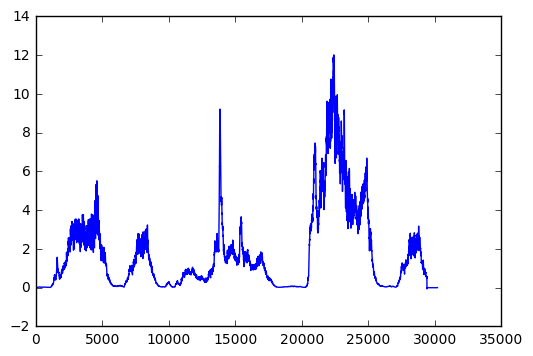

In [8]:
plt.plot(latent_par[:,3])

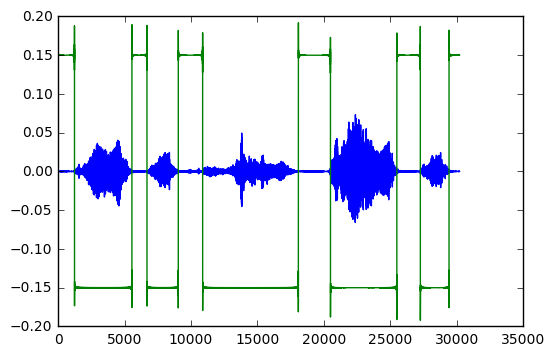

In [67]:
plt.plot(latent_par[:,0]/400000)
plt.plot(0.15 - latent_par[:,1])

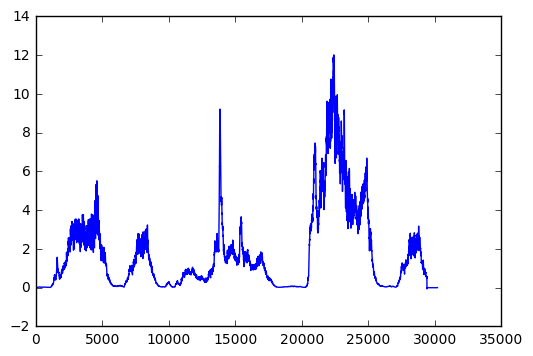

In [68]:
plt.plot(latent_par[:,3])


In [69]:
np.vstack([latent_par[:, 0], latent_par[:, 1]]).T.shape

(30212, 2)

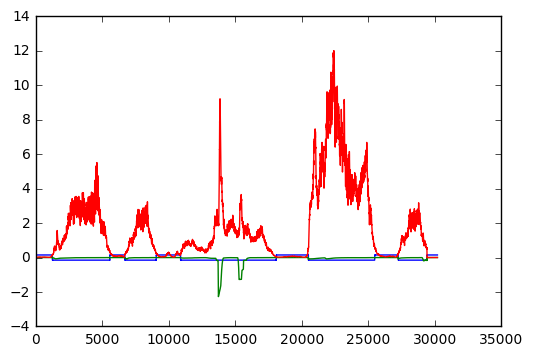

In [90]:
latent_par = syn.load_syn_stream(bird, syn_sess=syn_sess, 
                                             s_f=30000, 
                                             new_s_f=44100, 
                                             file_base='synth_bos_export')
def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    return np.vstack([0.15 - onof, -beta, alpha]).T

par_stream = latent_to_stream(latent_par[:, 1], latent_par[:, 2], latent_par[:, 3])
plt.plot(par_stream)

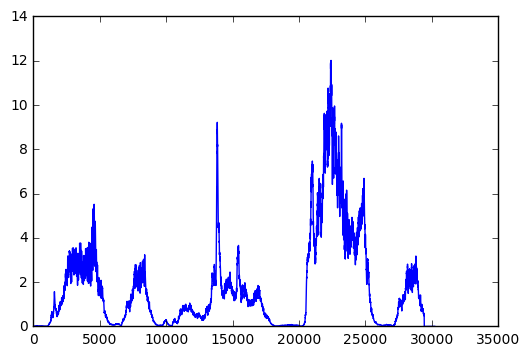

In [95]:
plt.plot(par_stream[:, 2])

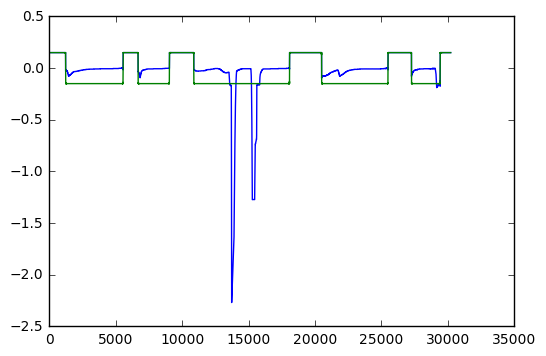

In [77]:
par_stream[par_stream[:,0]>0, 1] = .15
plt.plot(par_stream[:,1])
plt.plot(par_stream[:,0])

In [79]:
par_stream.dtype

dtype('float64')

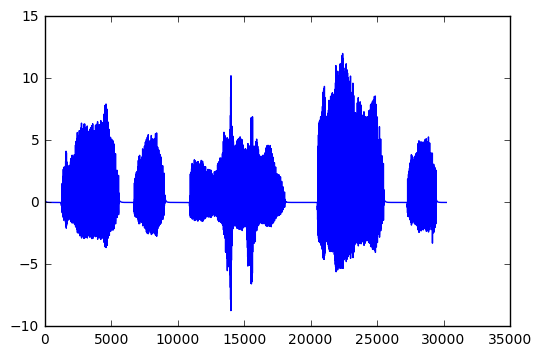

In [96]:
song_synth_after = zf.finch(vocal_pars, par_stream)
plt.plot(song_synth_after[:, 0])

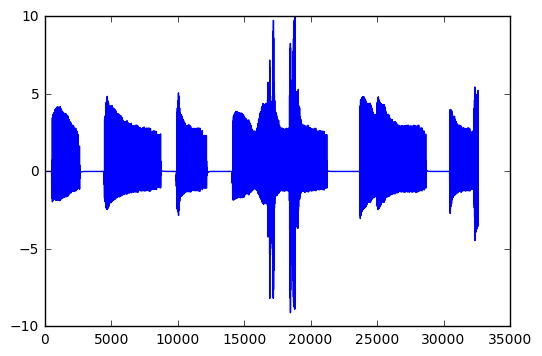

In [25]:
plt.plot(song_synth_after[:,0])